# Single step; adapted to Mars et al Hyperparameters 

In [132]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import mean
from numpy import std
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler

In [133]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out, step_interval):
    X, y = list(), list()
    example_count = int((len(sequence)/step_interval))
    for i in range(example_count):
        # find the end of this pattern
        end_ix = (i*step_interval) + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[(i*step_interval):end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [1]:
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2021-12-26 23:55:00' 
inputs = ['min_gas_price']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 2016
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1

### Generate Limited Training Split

In [240]:
def training_split_limited():
    #Load data as float, datetime to index
    data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum\data\min,max,average gas 11-26 to 01-26 QUERY 2.csv', header=0)
    data['block_timestamp'] = pd.to_datetime(data['block_timestamp'], format = '%Y-%m-%d %H:%M:%S UTC')
    data = data.set_index('block_timestamp')
    data = data.squeeze()
    data = data.astype('float')

    #Resample with left edge label i.e min 1-5 mean labelled as min1
    data = data.resample(resample_rate).mean()

    #Convert to gwei
    data = data.apply(lambda x: x/1000000000)
    data =data[inputs]

    #Filter inputs, set outlier limit
    data =data[inputs]
    data_mean, data_std = mean(data["min_gas_price"]), std(data["min_gas_price"])
    cut_off = data_std * 2
    lower, upper = data_mean - cut_off, data_mean + cut_off
    for index,row in data.iterrows():
      if row["min_gas_price"] < lower:
        row["min_gas_price"]=lower
      elif row["min_gas_price"] > upper:
        row["min_gas_price"]=upper

    #Filter inputs, set outlier limit
    data =data[inputs]
    scaler = MinMaxScaler()
    data[inputs] = scaler.fit_transform(data[inputs])





    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval)
    X_train, X_val = np.split(X, [int(0.7 * len(X))])
    y_train, y_val = y_train, y_val = np.split(y, [int(0.7 * len(X))])

    #Reshape to 3D for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
    y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], len(inputs)))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], len(inputs)))
    return X_train, y_train, X_val, y_val, scaler


### Generate Training Split with no limits

In [241]:
def training_split_no_limits():    
    #Load data as float, datetime to index
    data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum\data\min,max,average gas 11-26 to 01-26 QUERY 2.csv', header=0)
    data['block_timestamp'] = pd.to_datetime(data['block_timestamp'], format = '%Y-%m-%d %H:%M:%S UTC')
    data = data.set_index('block_timestamp')
    data = data.squeeze()
    data = data.astype('float')

    #Resample with left edge label i.e min 1-5 mean labelled as min1
    data = data.resample(resample_rate).mean()

    #Convert to gwei
    data = data.apply(lambda x: x/1000000000)
    data =data[inputs]

    #Filter inputs, set outlier limit
    data =data[inputs]
    scaler = MinMaxScaler()
    data[inputs] = scaler.fit_transform(data[inputs])


    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval)
    X_train2, X_val2 = np.split(X, [int(0.7 * len(X))])
    y_train2, y_val2 = y_train, y_val = np.split(y, [int(0.7 * len(X))])

    #Reshape to 3D for LSTM
    X_train2 = X_train2.reshape((X_train2.shape[0], X_train2.shape[1], len(inputs)))
    y_train2 =y_train2.reshape((y_train2.shape[0], y_train2.shape[1], len(inputs)))
    X_val2 = X_val2.reshape((X_val2.shape[0], X_val2.shape[1], len(inputs)))
    y_val2 = y_val2.reshape((y_val2.shape[0], y_val2.shape[1], len(inputs)))
    return X_train, y_train, X_val, y_val, scaler

In [242]:
X_train, y_train, X_val, y_val, scaler = training_split_limited()

In [243]:
X_train2, y_train2, X_val2, y_val2, scaler2 = training_split_no_limits()

## Define, train Model

In [254]:
# define model
model = Sequential()
model.add(LSTM(units =15,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01))
model.add(Dense(n_steps_out))
opt = keras.optimizers.Adam(learning_rate=0.01, decay=0.0001)
model.compile(optimizer='adam', loss='mse')

In [255]:
model.fit(X_train, y_train, epochs=25, verbose=1, validation_data =(X_val, y_val))

Epoch 1/25
152/152 [==============================] - 11s 57ms/step - loss: 0.0195 - val_loss: 0.0060
Epoch 2/25
152/152 [==============================] - 8s 53ms/step - loss: 0.0099 - val_loss: 0.0050
Epoch 3/25
152/152 [==============================] - 8s 53ms/step - loss: 0.0089 - val_loss: 0.0047
Epoch 4/25
152/152 [==============================] - 8s 52ms/step - loss: 0.0083 - val_loss: 0.0043
Epoch 5/25
152/152 [==============================] - 8s 52ms/step - loss: 0.0078 - val_loss: 0.0041
Epoch 6/25
152/152 [==============================] - 8s 53ms/step - loss: 0.0071 - val_loss: 0.0039
Epoch 7/25
152/152 [==============================] - 8s 53ms/step - loss: 0.0068 - val_loss: 0.0037
Epoch 8/25
152/152 [==============================] - 8s 52ms/step - loss: 0.0065 - val_loss: 0.0035
Epoch 9/25
152/152 [==============================] - 8s 52ms/step - loss: 0.0061 - val_loss: 0.0034
Epoch 10/25
152/152 [==============================] - 8s 53ms/step - loss: 0.0060 - val_l

In [60]:
model.save('Univariate_1block_')


INFO:tensorflow:Assets written to: Univariate_1block_2\assets


INFO:tensorflow:Assets written to: Univariate_1block_2\assets


In [249]:
yhat = model.predict(X_val, verbose=1)

65/65 [==============================] - 2s 24ms/step


# Evaluation

In [256]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score



In [257]:
def invert_minxmax (data):
    de_scaled = ((data)*(upper))
    return de_scaled

RMSE 13.630994412883549
MAE 8.823534837453893
MAPE 0.13432104361565603
R^2 0.6850601068572506
MSE 185.80400868406252


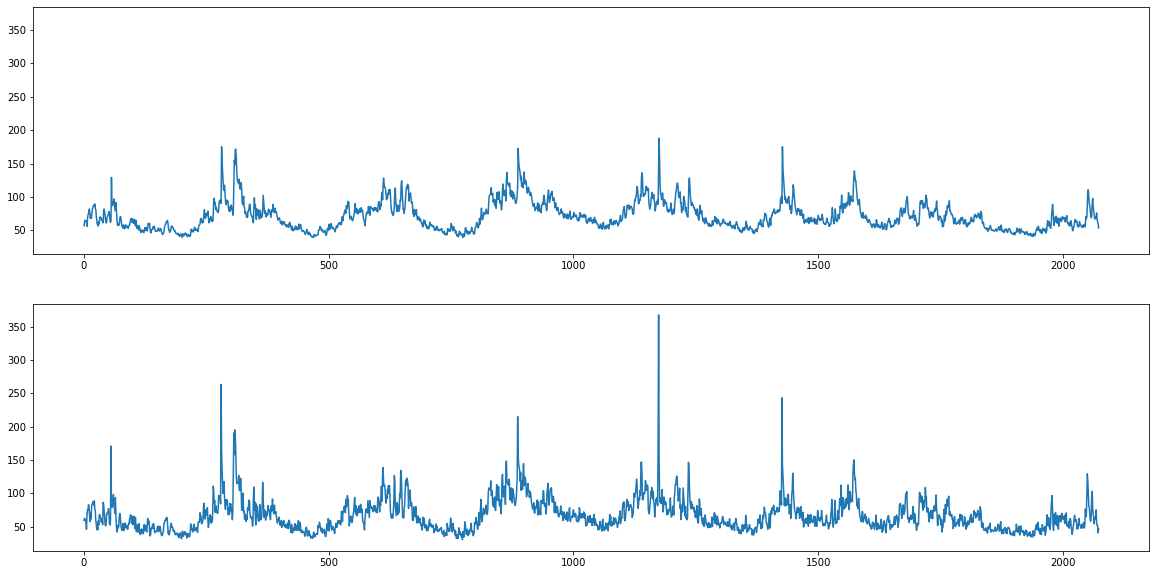

In [258]:
pred_descaled= scaler.inverse_transform(yhat.flatten().reshape(-1, 1))
groud_truth_descaled = scaler2.inverse_transform(y_val2.flatten().reshape(-1, 1))


f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(10)
ax1.plot(pred_descaled)
ax2.plot(groud_truth_descaled)



print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))
print('MSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled)))

## Lets try without limiting outliers


In [20]:
from sklearn.preprocessing import MinMaxScaler

In [101]:
#Load data as float, datetime to index
data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum\data\min,max,average gas 11-26 to 01-26 QUERY 2.csv', header=0)
data['block_timestamp'] = pd.to_datetime(data['block_timestamp'], format = '%Y-%m-%d %H:%M:%S UTC')
data = data.set_index('block_timestamp')
data = data.squeeze()
data = data.astype('float')

#Resample with left edge label i.e min 1-5 mean labelled as min1
data = data.resample(resample_rate).mean()

#Convert to gwei
data = data.apply(lambda x: x/1000000000)
data =data[inputs]

#Filter inputs, set outlier limit
data =data[inputs]
scaler = MinMaxScaler()
data[inputs] = scaler.fit_transform(data[inputs])
    

#Creat input:output examples
data = data[start_date:end_date].to_numpy()
X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval)
X_train, X_val = np.split(X, [int(0.7 * len(X))])
y_train, y_val = y_train, y_val = np.split(y, [int(0.7 * len(X))])


In [102]:
#Reshape to 3D for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], len(inputs)))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], len(inputs)))

In [73]:
# define model
model = Sequential()
model.add(LSTM(256, activation='tanh', input_shape=(n_steps_in, len(inputs))))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [109]:
model.save('Univariate_1block_#2_nothresh')

INFO:tensorflow:Assets written to: Univariate_1block_#2_nothresh\assets


INFO:tensorflow:Assets written to: Univariate_1block_#2_nothresh\assets


In [75]:
model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_val, y_val))

Epoch 1/10
152/152 [==============================] - 21s 138ms/step - loss: 7.2875e-04 - val_loss: 1.1678e-04
Epoch 2/10
152/152 [==============================] - 20s 134ms/step - loss: 5.8741e-04 - val_loss: 9.7719e-05
Epoch 3/10
152/152 [==============================] - 20s 135ms/step - loss: 5.1894e-04 - val_loss: 9.7408e-05
Epoch 4/10
152/152 [==============================] - 20s 134ms/step - loss: 4.8244e-04 - val_loss: 9.1036e-05
Epoch 5/10
152/152 [==============================] - 21s 135ms/step - loss: 4.7765e-04 - val_loss: 9.1753e-05
Epoch 6/10
152/152 [==============================] - 20s 134ms/step - loss: 4.5853e-04 - val_loss: 1.0270e-04
Epoch 7/10
152/152 [==============================] - 21s 135ms/step - loss: 4.6343e-04 - val_loss: 1.3482e-04
Epoch 8/10
152/152 [==============================] - 21s 139ms/step - loss: 4.5904e-04 - val_loss: 1.0115e-04
Epoch 9/10
152/152 [==============================] - 20s 134ms/step - loss: 4.6002e-04 - val_loss: 9.2272e-05
E

65/65 [==============================] - 3s 52ms/step
RMSE 13.807058249060713
MAE 8.653766379648264
MAPE 0.13347361600672517
R^2 0.6768717635677981
MSE 190.63485749295546


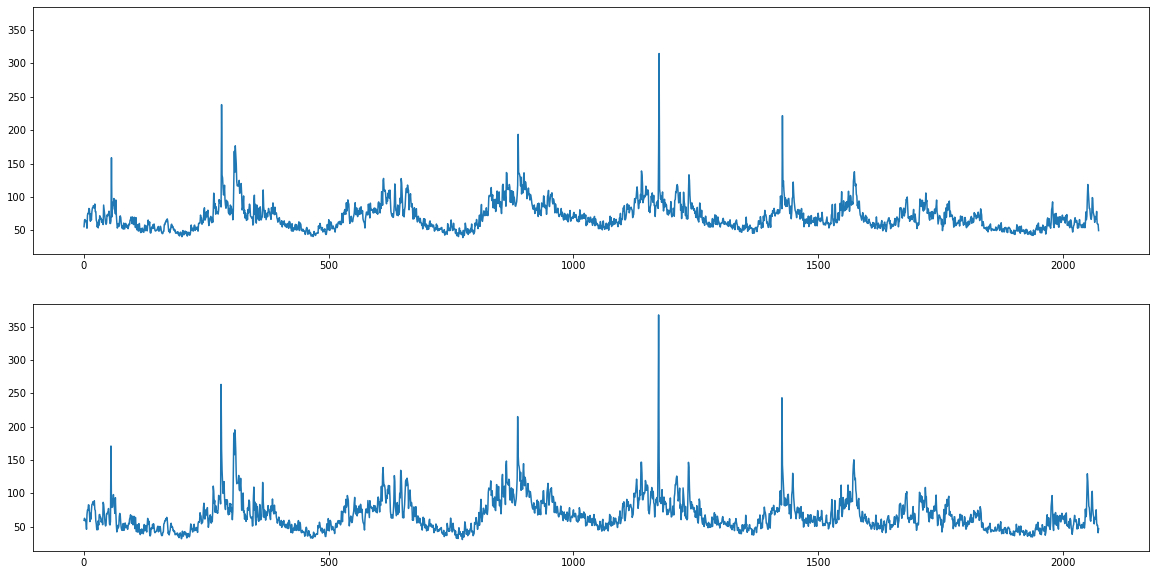

In [103]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
yhat2 = model.predict(X_val, verbose=1)

pred_descaled2= scaler.inverse_transform(yhat2.flatten().reshape(-1, 1))
groud_truth_descaled2 = scaler.inverse_transform(y_val.flatten().reshape(-1, 1))


f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(10)
ax1.plot(pred_descaled2)
ax2.plot(groud_truth_descaled2)



print('RMSE ' + str(mean_squared_error(groud_truth_descaled2, pred_descaled2, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled2, pred_descaled2)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled2, pred_descaled2)))
print('R^2 ' + str(r2_score(groud_truth_descaled2, pred_descaled2)))
print('MSE ' + str(mean_squared_error(groud_truth_descaled2, pred_descaled2)))

RMSE 13.052626058445936
MAE 8.092384499868015
MAPE 0.1210993037102698
R^2 0.7112191511710352
MSE 170.37104702162188


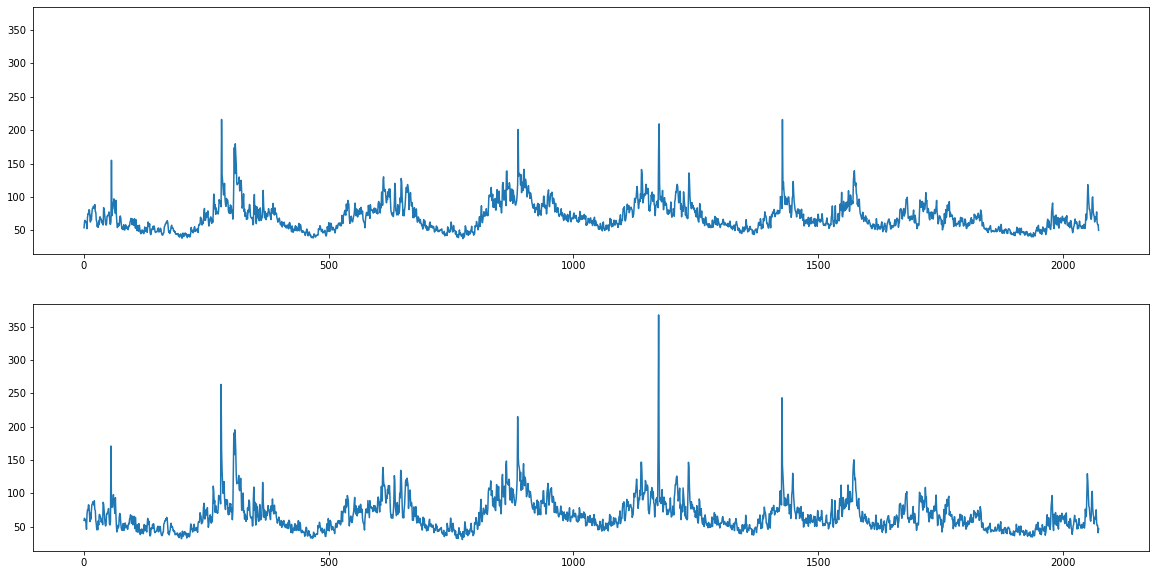

In [104]:
f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(10)
ax1.plot(pred_descaled1)
ax2.plot(groud_truth_descaled2)



print('RMSE ' + str(mean_squared_error(groud_truth_descaled2, pred_descaled1, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled2, pred_descaled1)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled2, pred_descaled1)))
print('R^2 ' + str(r2_score(groud_truth_descaled2, pred_descaled1)))
print('MSE ' + str(mean_squared_error(groud_truth_descaled2, pred_descaled1)))

In [105]:
def print_metrics (val, pred):
    print('RMSE ' + str(mean_squared_error(val, pred, squared=False)))
    print('MAE ' + str(mean_absolute_error(val, pred)))
    print('MAPE ' + str(mean_absolute_percentage_error(val, pred)))
    print('R^2 ' + str(r2_score(val, pred)))
    print('MSE ' + str(mean_squared_error(val, pred)))

In [108]:
print('training+val outleirs limited')
print_metrics(groud_truth_descaled1, pred_descaled1)

print('training outleirs limited, val unlimited')
print_metrics(groud_truth_descaled2, pred_descaled1)

print('No Limits')
print_metrics(groud_truth_descaled2, pred_descaled2)





training+val outleirs limited
RMSE 12.122864843536563
MAE 8.007239602220897
MAPE 0.1209417459952909
R^2 0.7339909996842746
MSE 146.96385201465478
training outleirs limited, val unlimited
RMSE 13.052626058445936
MAE 8.092384499868015
MAPE 0.1210993037102698
R^2 0.7112191511710352
MSE 170.37104702162188
No Limits
RMSE 13.807058249060713
MAE 8.653766379648264
MAPE 0.13347361600672517
R^2 0.6768717635677981
MSE 190.63485749295546


# Limiting training outliers improves all metrics aside from R^2

Limiting validation outliers also lowers error further, but we are not validating on actual data